

# ISS projekt

<center>

## Autor: Adam Běhoun
## login: xbehoua00

</center>

---

# Plán řešení
## Statistické vyhodnocování
Jako první nápad na vyřešení tohoto projektu bylo porovnat statistické hodnoty těchto signálů. Po výpočtu jsem ale narazil na problém, že tyto hodnoty byly pro všechny signály velmi podobné a nenapadlo mě řešení, jak je dostatečně odlišit.

Takto vypadaly výsledky pro dva různé referenční signály:



```
Referenční signál Subaru_Forester_Drive.wav:
  střední hodnota = 0.00
  rozptyl = 0.00
  minimum = -0.06
  maximum = 0.05
  šikmost = -0.34
  špičatost = 0.42

Referenční signál BMW_1_Drive.wav:
  střední hodnota = 0.00
  rozptyl = 0.00
  minimum = -0.09
  maximum = 0.08
  šikmost = 0.01
  špičatost = 0.23
```
## DTW
Po neúspěšném pokusu jsem začal hledat možná alternativní řešení. Na základě zdrojů [7][4] jsem dohledal, že se v tomto případě dá využít **DTW** [1] (Dynamic Time Warping), který umožňuje porovnávat signály tak, že zarovná dvě časové řady s cílem nejlepší shody. Tento algoritmus jsem se snažil implementovat, ale nedařilo se mi ho použít správně a nedostával jsem použitelné výsledky. Vzhledem k tomu, že tento algoritmus nebyl součástí výuky ISS, jsem se rozhodl tuto metodu ukončit a pokračovat v hledání jiného přístupu.

## Analýza frekvenčních spekter
Rozhodl jsem se tedy k analýze frekvenčních spekter, kterou jsem znal z přednášek. Při prvotním pokusu jsem jednoduše udělal Fourierovu transformaci, a metodou korelačního koeficientu jsem zkoumal podobnost. Očekávaně jsem dostal nejednoznačné výsledky, které nebyly použitelné.

 Začal jsem tedy blíže zkoumat signály jako takové a bylo zřejmé, že tam je mnoho šumu. Bylo třeba využít nějaký filtr, který tento signál nějak upraví.

#### **Jednoduchý klouzavý průměr [6]**
Jako první jsem využil tento filtr, který sice signál krásně vyhladil, ale frekvenční spektra byla natolik podobná u všech signálů, že výsledky metrik na podobnost byly skoro nerozpoznatelné a nesmyslné.

#### **Savitzky-Golay filter [6]**
S tímto filtrem jsem dostal obdobné výsledky jako u jednoduchého klouzavého průměru. V tuto chvíli jsem usoudil, že vyhlazování signálu pravděpodobně není ten správný směr.

#### **Pásmová propust**
Pro tento filtr bylo nutné najít správné hranice propustnosti. Většina zvuků motoru se typicky nachází ve frekvenčním pásmu 20Hz - 2kHz [2]. Zvolil jsem tedy tyto hranice a výsledky filtrace byly uspokojivé.

---

I přes vhodně zvolený filtr jsem nedostával jednoznačné výsledky, a tak jsem se zaměřil na fakt, že bude třeba nějakým způsobem normalizovat různé otáčky v nahrávkách. Zvolil jsem normalizaci fundamentální frekvence, ze které se dá vypočítat, na kolik otáček motor běží [3]. Pokud normalizuji všechny signály, tak sice nezajistím že tyto signály budou všechny běžet na stejných otáčkách (to zálěží na počtu válců), ale pokud testovací nahrávka pochází ze stejného auta jako referenční, tak tyto dvě nahrávky budou mít stejné otáčky a jejich porovnání bude přesnější.

## Zvolené metriky
 1. **Křížová korelace** (cross-correlation) [4]: Posouváme jedním signálem přes druhý a měříme jejich podobnost v různých posunech. Tato metrika velmi vhodná, protože se tak zbavíme problému s posunutými nahrávkami. Čím více jsou signály podobné, tím je koeficient větší. koeficient je z intervalu <-1, 1>. V kódu jsem zvolil hranici podobnosti *0.5*. Tedy signály s korelačním koeficientem pod touto hranicí budou vyhodnoceny jako nepodobné.
 2. **Euklidovská vzdálenost** [4]: Tato metrika překryje jeden signál druhým a měří vzdálenost mezi jednotlivými body signálů. Čím více jsou signály podobné, tím menší je výsledná vzdálenost. Tuto metriku jsem zvolil k ověření výsledků křížové korelace.
 3. **Cosinova podobnost**: Zde se opět dva signály překryjí a měří se, zda jsou signály podobné z hlediska směru jejich hodnot. Nebere se ohled na jejich velikost. Tedy pokud je úhel *0*, hodnota se blíží *1* a signály jsou podobné. Tato metrika opět slouží spíše k ověření výsledků křížové korelace.

# Implementace

In [ ]:
# needed
import os
import re
import glob
import soundfile as sf
from IPython.display import Audio
from IPython.display import display
# recommended ...
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft, ifft, fftfreq
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

import librosa
!pip install noisereduce
import noisereduce as nr
from scipy.spatial.distance import euclidean


In [ ]:
# read the file
login = "xbehoua00"
zip_file = login + ".zip"
assignment_file = "https://www.fit.vut.cz/study/course/ISS/public/proj2024-25/personal/" + zip_file
!wget $assignment_file
!unzip -o $zip_file

--2024-12-16 22:19:26--  https://www.fit.vut.cz/study/course/ISS/public/proj2024-25/personal/xbehoua00.zip
Resolving www.fit.vut.cz (www.fit.vut.cz)... 147.229.9.65, 2001:67c:1220:809::93e5:941
Connecting to www.fit.vut.cz (www.fit.vut.cz)|147.229.9.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211884 (207K) [application/zip]
Saving to: ‘xbehoua00.zip’

xbehoua00.zip       100%[===================>] 206.92K   260KB/s    in 0.8s    

2024-12-16 22:19:28 (260 KB/s) - ‘xbehoua00.zip’ saved [211884/211884]

Archive:  xbehoua00.zip
   creating: xbehoua00/
  inflating: xbehoua00/Subaru_Forester_Drive.wav  
  inflating: xbehoua00/test_i.wav    
  inflating: xbehoua00/BMW_1_Drive.wav  
  inflating: xbehoua00/test_c.wav    
  inflating: xbehoua00/Opel_Corsa_Drive.wav  
  inflating: xbehoua00/test_g.wav    
  inflating: xbehoua00/BMW_318i_Drive.wav  
  inflating: xbehoua00/test_t.wav    


In [ ]:
# load the data
# references will be in ref_signals, reference labels in ref_labels, reference count in N_ref.
# tests  will be in test_signals, test labels in test_labels, test count in N_test.
def get_signals(labs):
    signals = []
    N = len(labs)
    for car in labs:
      filename = login + "/" + car + ".wav"
      s, Fs = sf.read(filename)
      signals.append(s)
    return signals, N, Fs

def play_signals(signals, Fs):
  for signal in signals:
    display(Audio(signal, rate=Fs))

files = glob.glob(login + "/*.wav")
names = [re.sub(login + "/", "", s) for s in files]
labels = [re.sub(".wav", "",s) for s in names]
print ("----- test signals ---------")
r = re.compile("^test_");  test_labels = list(filter(r.match, labels))
print (test_labels); test_signals, N_test, Fs = get_signals(test_labels); play_signals (test_signals, Fs)
print ("----- reference signals ---------")
r = re.compile("(?!^test_)");  ref_labels = list(filter(r.match, labels))
print (ref_labels); ref_signals, N_ref, Fs = get_signals(ref_labels); play_signals (ref_signals, Fs)

----- test signals ---------
['test_g', 'test_c', 'test_i', 'test_t']


----- reference signals ---------
['Subaru_Forester_Drive', 'Opel_Corsa_Drive', 'BMW_318i_Drive', 'BMW_1_Drive']


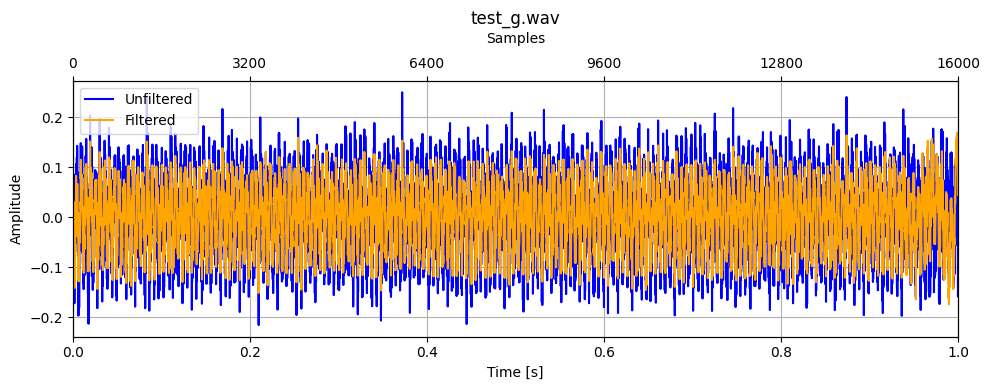

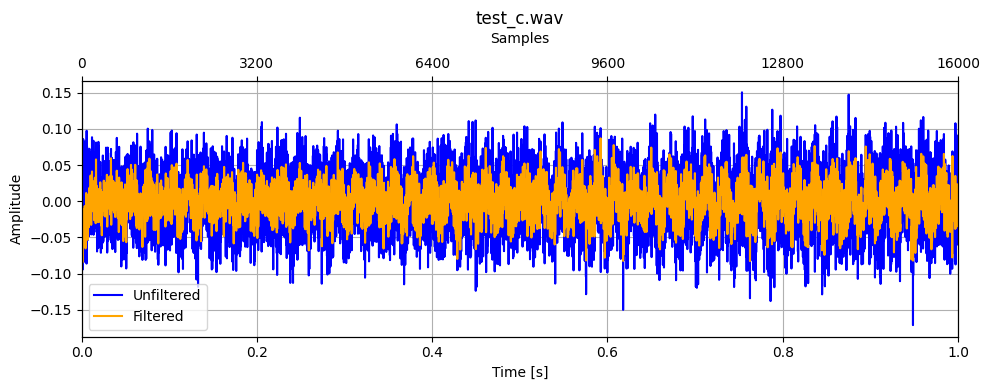

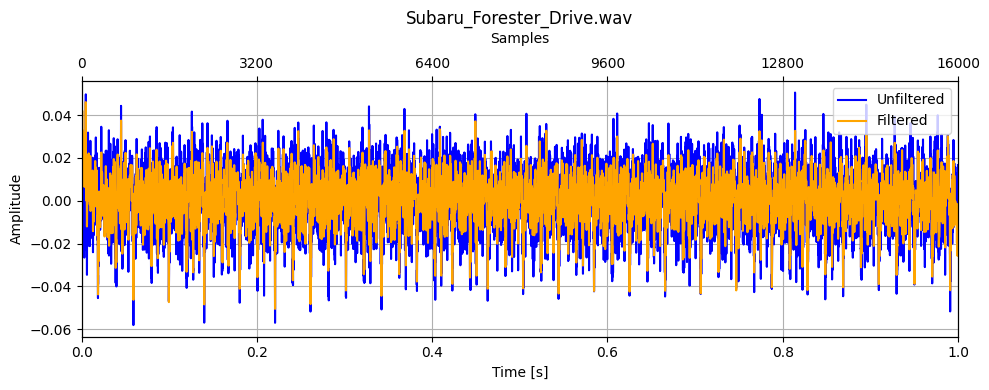

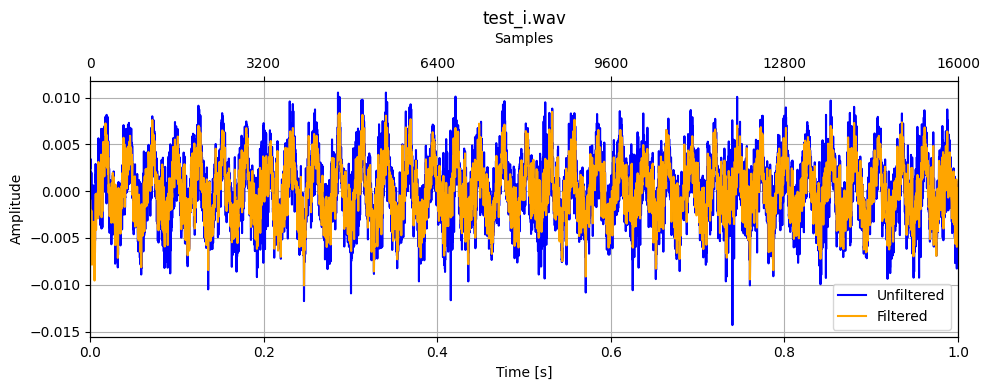

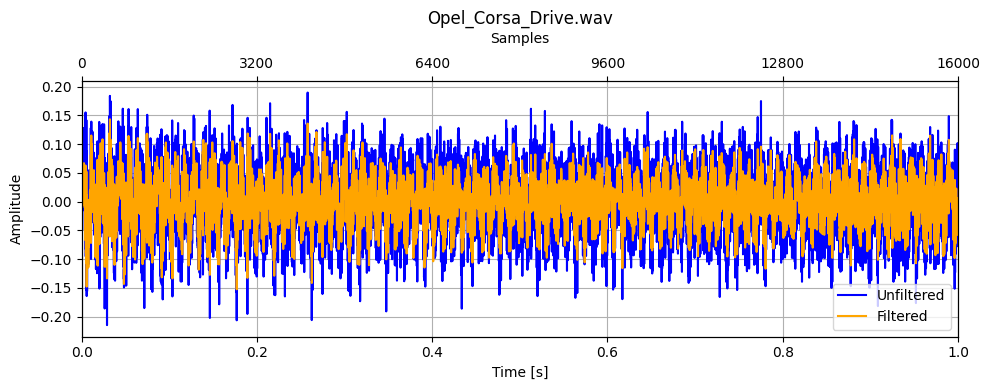

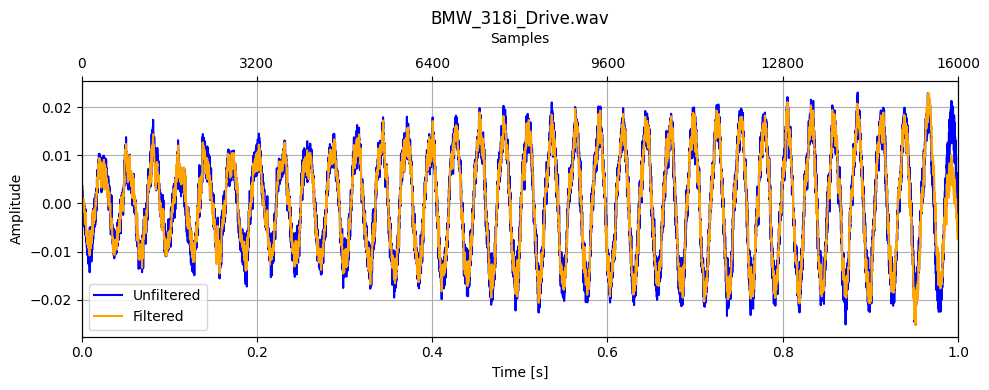

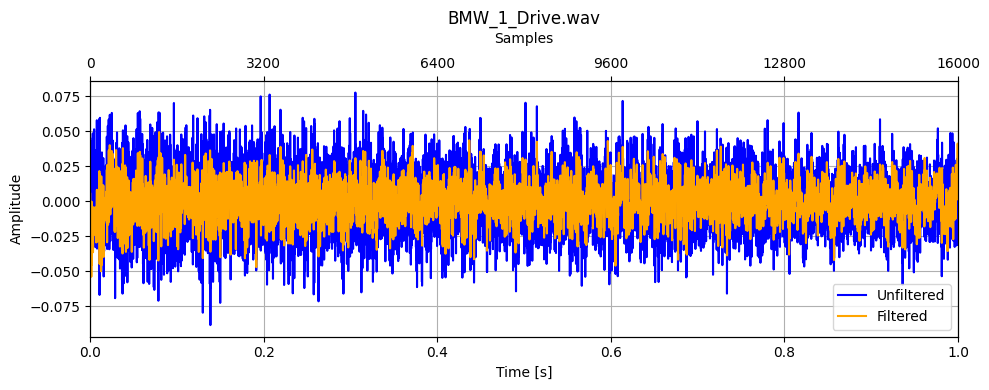

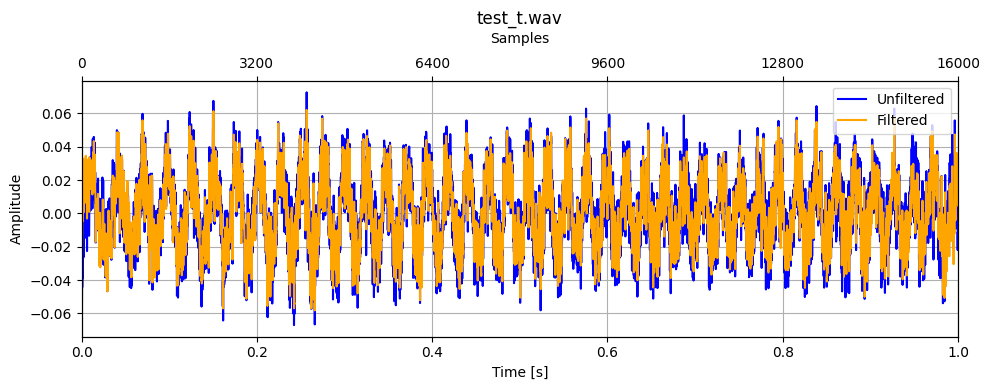

In [ ]:
# Implementation of bandpass filter from lowcut to highcut
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    y = signal.filtfilt(b, a, data)
    return y

def visualize(audio_file: str, title: str):
    data, sr = sf.read(audio_file)

    # filter the data using the bandpass filter
    filtered_data = bandpass_filter(data, 20, 2000, sr)

    time = np.arange(data.size) / sr

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_xlim(min(time), data.size/sr)

    ax.plot(time, data, color='blue', label="Unfiltered")
    ax.plot(time, filtered_data, color='orange', label="Filtered")

    ax.set_title(title)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")
    ax.grid()
    ax.legend()

    # axis for samples
    ax2 = ax.twiny()
    ax2.set_xlabel("Samples", labelpad=10)
    xticks = ax.get_xticks()
    ax2.set_xticks(np.round(xticks * sr).astype(int))
    ax2.set_xlim(0, data.size)

    plt.tight_layout()
    plt.show()

for audio, name in zip(files, names):
    visualize(audio, name)

Zkusím si vyfiltrované signály pomocí pásmové propusti spustit, aby jsem si ověřil, zda se filtrace vydařila.

In [ ]:
def play_filtered_signals(signals, Fs):
    filtered_signals = [bandpass_filter(signal, 20, 2000, Fs) for signal in signals]
    for signal in filtered_signals:
        display(Audio(signal, rate=Fs))

print ("----- filtered test signals ---------")
r = re.compile("^test_");  test_labels = list(filter(r.match, labels))
print (test_labels); test_signals, N_test, Fs = get_signals(test_labels); play_filtered_signals (test_signals, Fs)
print ("----- flitered reference signals ---------")
r = re.compile("(?!^test_)");  ref_labels = list(filter(r.match, labels))
print (ref_labels); ref_signals, N_ref, Fs = get_signals(ref_labels); play_filtered_signals (ref_signals, Fs)

----- filtered test signals ---------
['test_g', 'test_c', 'test_i', 'test_t']


----- flitered reference signals ---------
['Subaru_Forester_Drive', 'Opel_Corsa_Drive', 'BMW_318i_Drive', 'BMW_1_Drive']


Dále jsem u každého signálu identifikoval **fundamentální frekvenci**, která charakterizuje jeho základní tón. Z těchto frekvencí jsem následně vypočítal průměr a tuto hodnotu jsem uložil do proměnné, která je využita při pozdější úpravě tónů jednotlivých signálů. Identifikaci jsem udělal pomocí autokorelace a použítí funkce find_peaks. Z autokorelační funkce vezmeme pouze kladnou polovinu a vyhledáme první "peak". Podle vztahu *f_0 = vzorkovací frekvence / první "peak"* získáme tuto fundamentální frekvenci.

In [ ]:
# list to store the fundamental frequencies
fund_f = []

# variable to track the sum of f_0
total = 0

def fundamental_frequency(audio_file:str, title:str):
    global total
    signal, sr = sf.read(audio_file)

    f_data = signal

    # autocorrelation
    autocorr = np.correlate(f_data, f_data, mode='full')
    mid = len(autocorr) // 2
    # cut in the half
    autocorr = autocorr[mid:]
    peaks, _ = scipy.signal.find_peaks(autocorr)

    # find first peak and calculate the f_0
    if len(peaks) > 0:
        first_peak = peaks[0]
        f_0 = sr / first_peak
        total = total + f_0
        if "test_" in title:
            print(f"{f_0} for {title}")
            fund_f.append(f_0)
        else:
            print(f"{f_0} for {title}")
            fund_f.append(f_0)
    else:
        return None

for audio, name in zip(files, names):
    fundamental_frequency(audio, name)

# calculate the average
avg_f0 = total / len(fund_f)
print(f"Average f0 is {avg_f0}")

2666.6666666666665 for test_g.wav
5333.333333333333 for test_c.wav
2285.714285714286 for Subaru_Forester_Drive.wav
1777.7777777777778 for test_i.wav
2000.0 for Opel_Corsa_Drive.wav
2000.0 for BMW_318i_Drive.wav
5333.333333333333 for BMW_1_Drive.wav
2000.0 for test_t.wav
Average f0 is 2924.6031746031745


Teď už si můžeme zobrazit **Fourierovu transformaci**. Modrou barvou je DFT původního signálu a oranžovou je DFT vyfiltrovaného signálu pomocí pásmové propusti. Vidíme, že filtr je účinný a skutečně filtruje frekvence nad 2kHz.

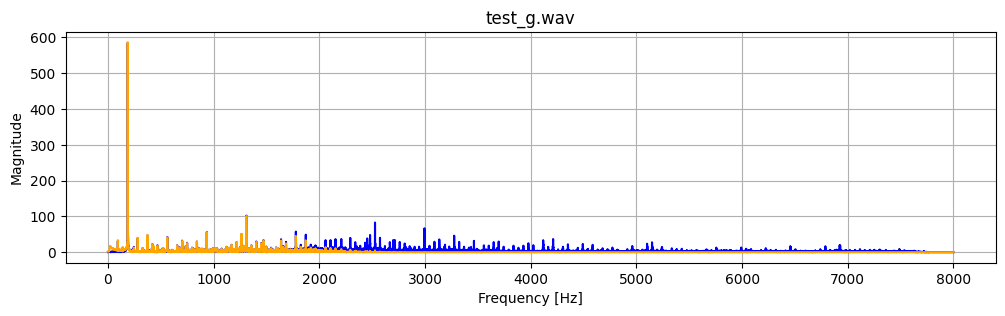

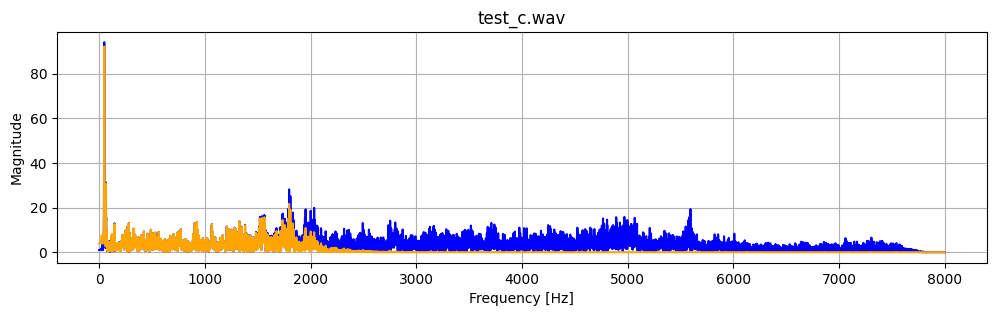

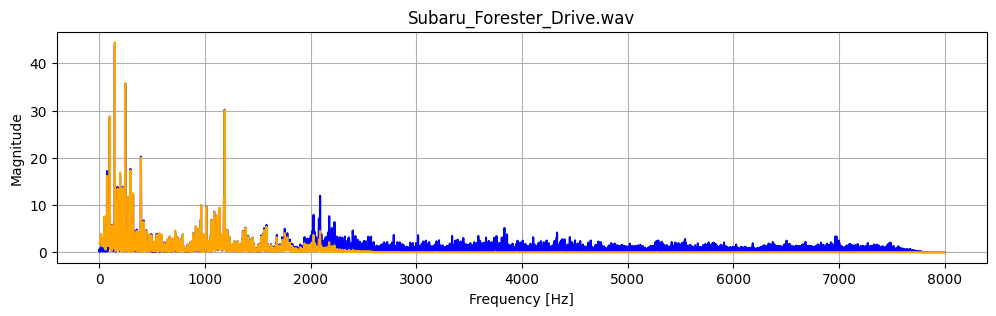

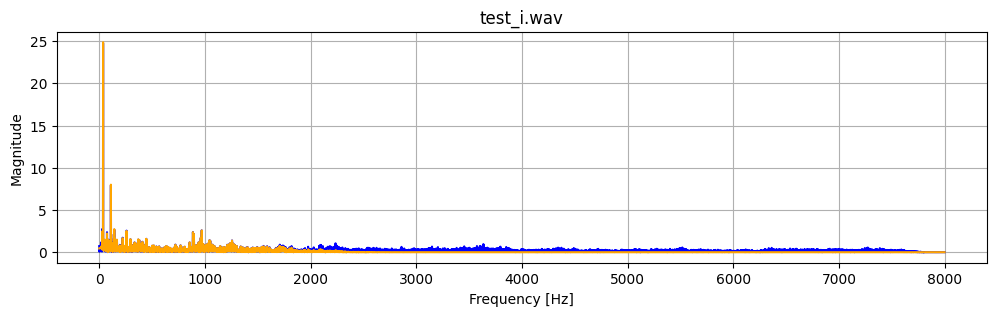

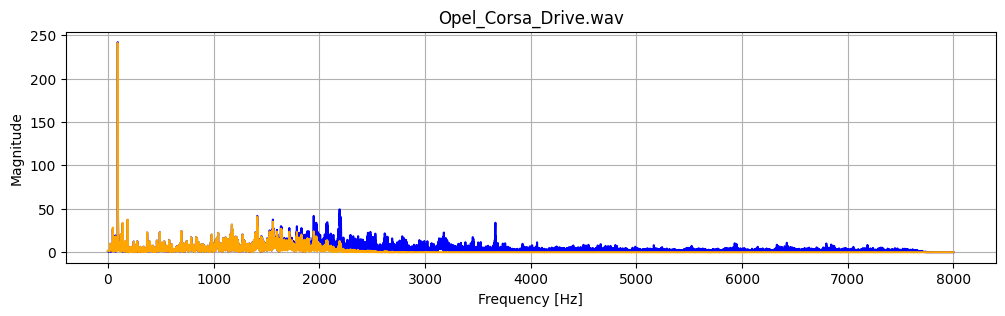

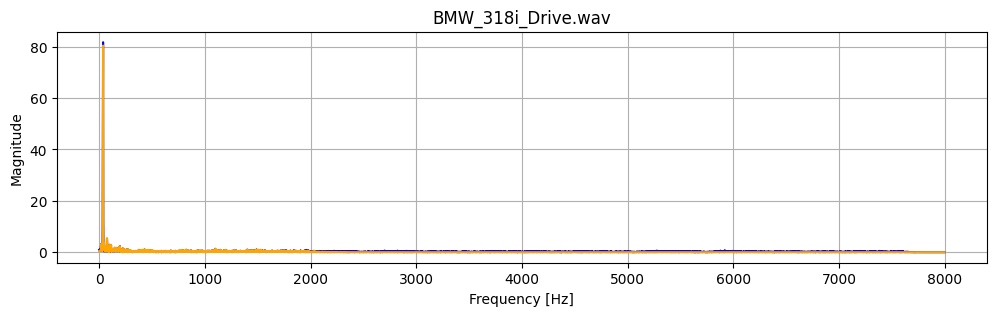

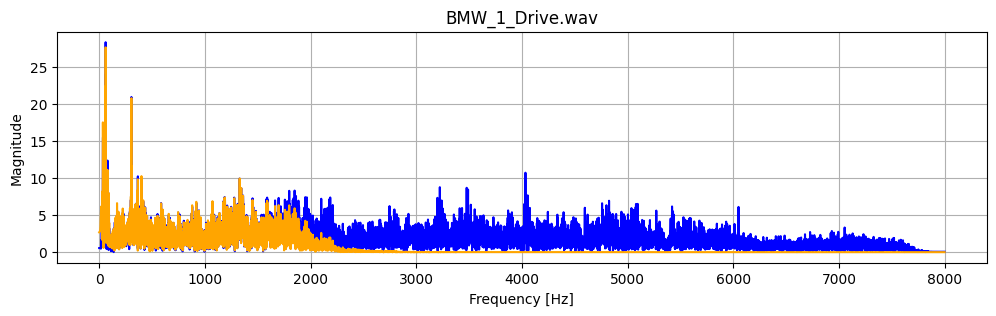

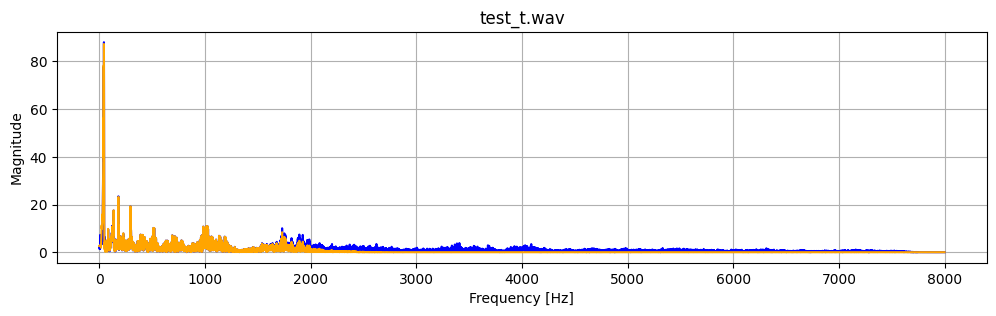

In [ ]:
def calculate_fft(signal, sampleRate, log=False):

    fourier = fft(signal)

    n = signal.size
    timestep = 1/sampleRate
    freq = fftfreq(n, d=timestep)

    # since FFT is symetric, we can keep only half of the coefficients
    magnitudes = np.abs(fourier[:n // 2])
    freq = freq[:n // 2]

    # if flag, apply logarithm on magnitudes and cut it from 20Hz to 2kHz
    if log:
        # add small constant to avoid log(0)
        magnitudes = np.log10(magnitudes + 1e-10)
        low = np.searchsorted(freq, 20)
        high = np.searchsorted(freq, 2000)
        freq = freq[low:high]
        magnitudes = magnitudes[low:high]

    return magnitudes, freq

def visualize_fft(audio_file: str, title:str, apply_log: bool):
    data, sr = sf.read(audio_file)

    # apply the bandpass filter with lowcut of 20Hz and highcut of 2kHz
    filtered_data = bandpass_filter(data, 20, 2000, sr)

    mag, freq = calculate_fft(data, sr, apply_log)
    d_mag, f_freq = calculate_fft(filtered_data, sr, apply_log)

    if apply_log == True:
        mag = normalize_magnitudes(mag)
        #f_mag = normalize_magnitudes(f_mag)
        #d_mag = normalize_magnitudes(d_mag)

    plt.subplots(figsize=(12,3))

    plt.plot(freq, mag, color="blue")

    plt.plot(freq, d_mag, color="orange")
    plt.title(title)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

for audio, name in zip(files, names):
    visualize_fft(audio, name, False)


Z grafů frekvenčních spekter signálů je patrné, že dominantní frekvenční složky výrazně převyšují méně výrazné složky. Aby jsem tento problém zmírnil, celé spektrum **zlogaritmuji**. Dále jsem spektrum ořízl na frekvenční rozsah 20 Hz až 2 kHz, protože tento rozsah odpovídá zvolenému filtru.

Operace pitch_shift [5] je použita k normalizaci základní frekvence, kterou jsem si vypočítal dříve v programu. Bez tohoto kroku jsem nedostával dostatečně jednoznačné výsledky. Také si jednotlivá spektra uložím do polí pro další analýzu.

Shifting by 1.5984406357957126


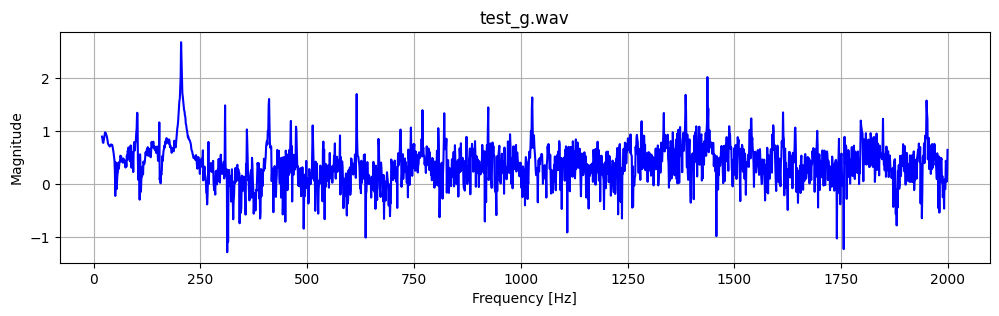

Shifting by -10.401559364204289


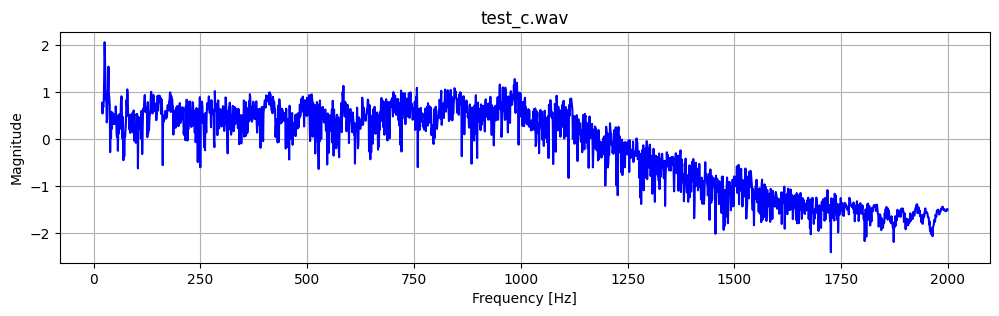

Shifting by 4.267149691833088


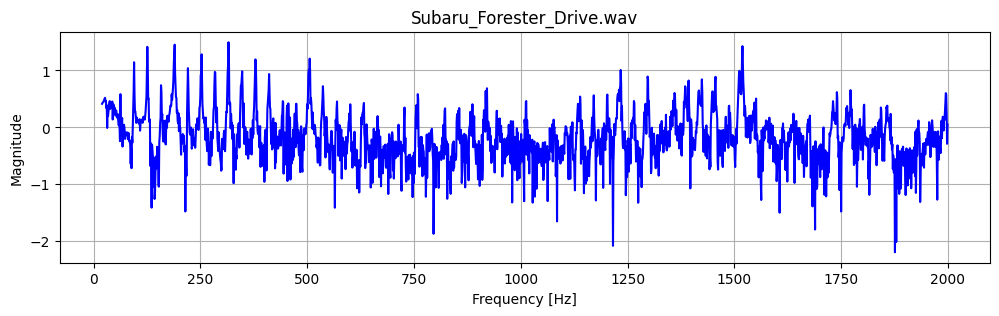

Shifting by 8.617990644449584


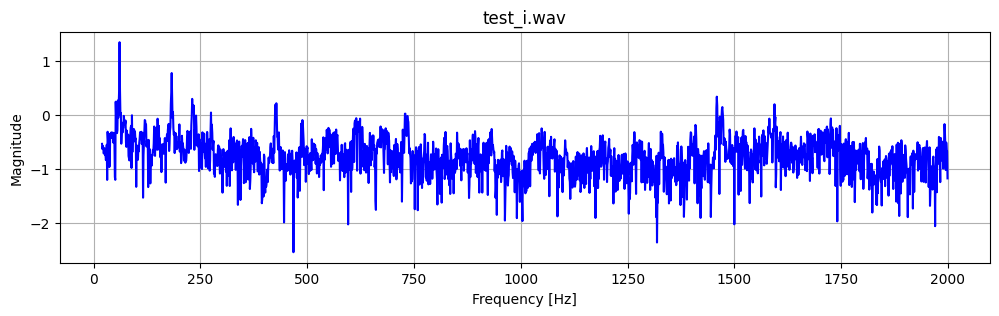

Shifting by 6.578890627141838


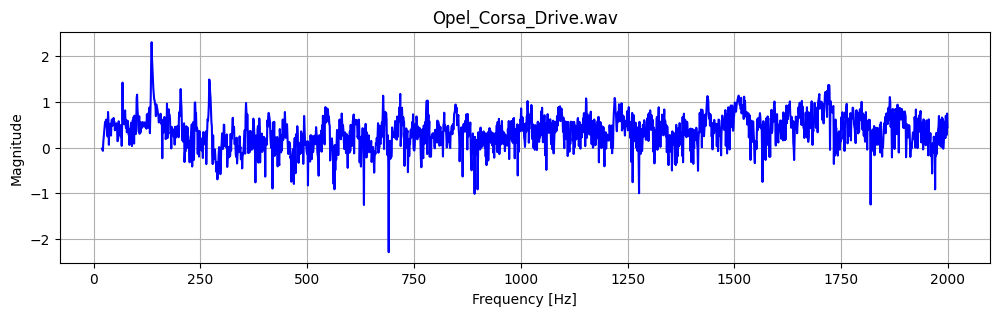

Shifting by 6.578890627141838


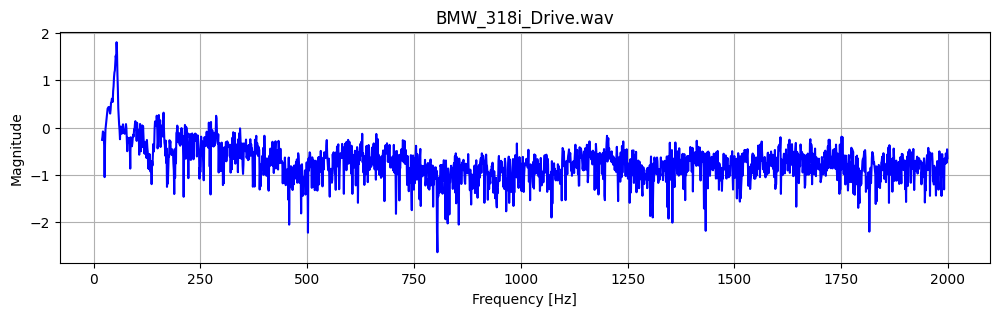

Shifting by -10.401559364204289


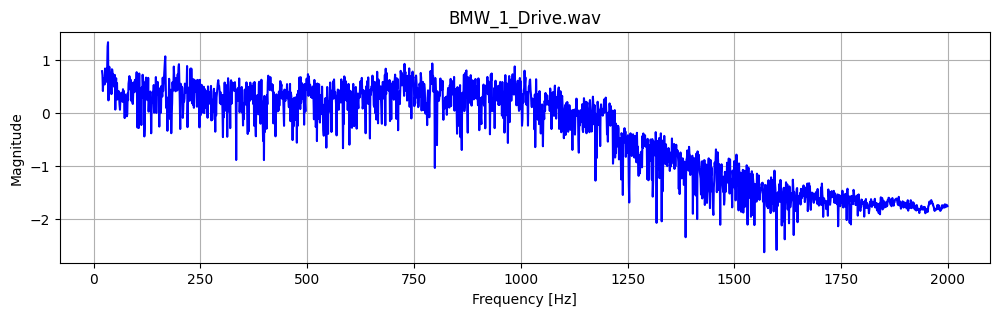

Shifting by 6.578890627141838


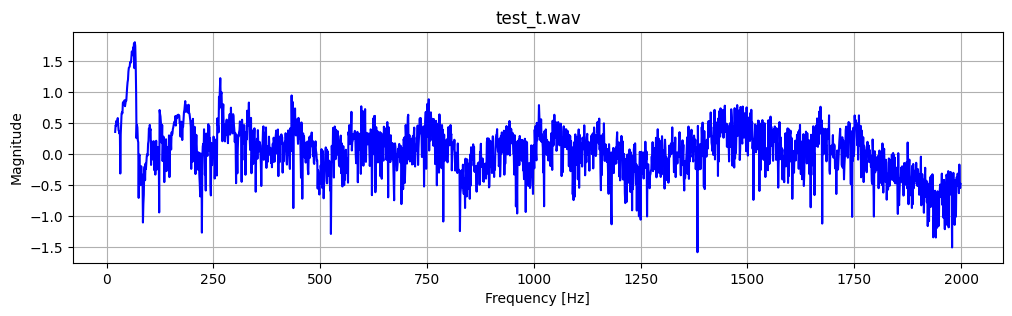

In [ ]:
fa_test=[]
fa_ref=[]

# adjust the fundamental frequency to the average of all the fundamental
# frequencies using librosa function pitch_shift
def adjust_signal_f0(signal, f0, reference_f0, sr):
    n_steps = 12 * np.log2(reference_f0 / f0)
    print(f"Shifting by {n_steps}")
    adjusted_signal = librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)
    return adjusted_signal

def visualize_adjusted(audio_file: str, title: str, i):
    data, sr = sf.read(audio_file)

    # apply the bandpass filter with lowcut of 20Hz and highcut of 2kHz
    data = bandpass_filter(data, 20, 2000, sr)

    # find the calculated fundamental frequency
    f0 = fund_f[i]

    data = adjust_signal_f0(data, f0, avg_f0, sr)

    mag, freq = calculate_fft(data, sr, True)

    # store the spectrum in the list
    if "test_" in title:
        fa_test.append((mag,freq))
    else:
        fa_ref.append((mag,freq))

    plt.subplots(figsize=(12,3))

    plt.plot(freq, mag, color="blue")

    #plt.plot(freq, d_mag, color="orange")
    plt.title(title)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

i = 0
for audio, name in zip(files, names):
    visualize_adjusted(audio, name, i)
    i+=1

Pro porovnávaní signálů použiji křížovou korelaci, cosinovu podobnost a Euklidovskou vzdálenost. Hranici korelace a cosinovy podobnosti nastavím na 0.5, bude-li výsledek menší než tato hodnota, tak vyhodnotím podobnost jako nedostatečnou. U Euklidovsk0 vzdálenosti nebudu nastavovat hranici, bude sloužit pouze pro ověření výsledků. V jednotlivých metrikách také normalizuji magnitudy ve frekvenčních spektrech, abych mohl tyto spektra porovnávat.

In [ ]:
test_names = []
ref_names = []
for name in names:
    if "test_" in name:
        test_names.append(name)
    else:
        ref_names.append(name)


def normalize_magnitudes(magnitudes):
    # normalize the magnitudes
    magnitudes = np.array(magnitudes)
    norm_value = np.linalg.norm(magnitudes)
    # avoid division by zero
    if norm_value != 0:
        return magnitudes / norm_value
    else:
        return magnitudes

def best_corr_signal(ref_list, test_signal):
    # track of index and max correlation
    max_corr = -float('inf')
    index = -1
    for i in range(0, len(ref_list)):
        r_mag, r_freq = ref_list[i]
        t_mag, t_freq = test_signal

        # normalize the magnitudes
        r_mag = normalize_magnitudes(r_mag)
        t_mag = normalize_magnitudes(t_mag)

        corr_value = np.max(np.correlate(t_mag, r_mag, mode='full'))
        #corr_value = np.corrcoef(r_mag, t_mag)[0, 1]

        if corr_value > max_corr:
            max_corr = corr_value
            index = i

    # threshold 0.5
    if max_corr < 0.5:
        return -1, max_corr
    else:
        return index, max_corr

def cosine_method(ref_list, test_signal):
    # track of maximal similarity and index
    max_cosine = -float('inf')
    index = -1
    for i in range(0, len(ref_list)):
        r_mag, r_freq = ref_list[i]
        t_mag, t_freq = test_signal

        dot_product = np.dot(r_mag, t_mag)
        norm_r_mag = np.linalg.norm(r_mag)
        norm_t_mag = np.linalg.norm(t_mag)

        cos_value = dot_product / (norm_r_mag * norm_t_mag)

        if cos_value > max_cosine:
            max_cosine = cos_value
            index = i

    # threshold 0.5
    if max_cosine < 0.5:
        return -1, max_cosine
    else:
        return index, max_cosine

def euclidean_method(ref_list, test_signal):
    min_distance = float('inf')
    index = -1
    for i in range(0, len(ref_list)):
        r_mag, r_freq = ref_list[i]
        t_mag, t_freq = test_signal

        distance = scipy.spatial.distance.euclidean(r_mag, t_mag)

        if distance < min_distance:
            min_distance = distance
            index = i

    return index, min_distance

Tyto metody teď spustím na frekvenční spektra, které jsou uloženy v polích.

In [ ]:
corr_matches_fa = []
print("CORRELATION")
for i, test_signal in enumerate(fa_test):
    index, corr = best_corr_signal(fa_ref, test_signal)

    if index == -1:
        print(f"Signal {test_names[i]} did not meet the threshold.")
        corr_matches_fa.append(('no match', corr))
    else:
        print(f"Signal {test_names[i]} -> {ref_names[index]} with correlation {corr}.")
        corr_matches_fa.append((index, corr))

cosine_matches_fa = []
print("COSINE SIMILARITY")
for i, test_signal in enumerate(fa_test):
    index, cosine = cosine_method(fa_ref, test_signal)

    if index == -1:
        print(f"Signal {test_names[i]} did not meet the threshold.")
        cosine_matches_fa.append(('no match', cosine))
    else:
        print(f"Signal {test_names[i]} -> {ref_names[index]} with cosine {cosine}.")
        cosine_matches_fa.append((index, cosine))

eucl_matches_fa = []
print("EUCLIDEAN DISTANCE")
for i, test_signal in enumerate(fa_test):
    index, distance = euclidean_method(fa_ref, test_signal)

    if index == -1:
        print(f"Signal {test_names[i]} did not meet the threshold.")
        eucl_matches_fa.append(('no match', distance))
    else:
        print(f"Signal {test_names[i]} -> {ref_names[index]} with distance {distance}.")
        eucl_matches_fa.append((index, distance))

CORRELATION
Signal test_g.wav -> Opel_Corsa_Drive.wav with correlation 0.5648341681093133.
Signal test_c.wav -> BMW_1_Drive.wav with correlation 0.8954919843371805.
Signal test_i.wav -> BMW_318i_Drive.wav with correlation 0.8466363645138091.
Signal test_t.wav did not meet the threshold.
COSINE SIMILARITY
Signal test_g.wav -> Opel_Corsa_Drive.wav with cosine 0.5623226073899298.
Signal test_c.wav -> BMW_1_Drive.wav with cosine 0.8954919843371808.
Signal test_i.wav -> BMW_318i_Drive.wav with cosine 0.843057494651892.
Signal test_t.wav did not meet the threshold.
EUCLIDEAN DISTANCE
Signal test_g.wav -> Opel_Corsa_Drive.wav with distance 22.071433153338578.
Signal test_c.wav -> BMW_1_Drive.wav with distance 19.391865042170664.
Signal test_i.wav -> BMW_318i_Drive.wav with distance 21.239820161180173.
Signal test_t.wav -> Subaru_Forester_Drive.wav with distance 26.894586901765653.


# Závěr
Po počátečních neúspěšných metodách jsem si nebyl jistý, jestli pro tento projekt mám potřebné znalosti. Prošel jsem si pro to znovu výukové materiály a začal to s řešením znovu. Po provedení předzpracování signálů pomocí různých filtrů a normalizování fundamentální frekvence, jsem aplikoval více než jednu metriku pro podobnost signálů, aby jsem si ověřil své výsledky. Z těchto metrik plynou jednoznačné hodnoty, s kterými jsem spokojen a shodují se s mým počátečním přiřazením podle sluchu. Tento projekt mi poskytl lepší pochopení zvukových signálů v praxi a různých přístupů pro jejich zpracování.



---

<center>

### Výsledky

</center>


\begin{array}{|c|c|c|}
\hline
\textbf{Testovací signál} & \textbf{Referenční signál} & \textbf{Korelace} \\
\hline
\text{test_g.wav} & \text{Opel_Corsa_Drive.wav} & 0.5648 \\
\text{test_c.wav} & \text{BMW_1_Drive.wav} & 0.8955 \\
\text{test_i.wav} & \text{BMW_318i_Drive.wav} & 0.8466 \\
\text{test_t.wav} & - & - \\
\hline
\end{array}




# Zdroje

[1] R. Tavenár, "Dynamic Time Warping (DTW) v Pythonu," Rta Venar. [Online]. Dostupné: https://rtavenar.github.io/blog/dtw.html.

[2] Kureshee, A., Mandal, D. K., a Narayanan, S., "Twin bi-component drops' evaporation in an acoustic field: The amplitude influence," ResearchGate, [Online]. Dostupné: https://www.researchgate.net/figure/Frequency-ranges-of-noise-sources_tbl1_305682374.

[3] Y.M. Engineering Consultants, "Car Engine Signal Analysis," [Online]. Dostupné: http://www.ymec.com/hp/signal2/car1.htm.

[4] Makeability Lab, "Comparing Signals," [Online]. Dostupné: https://makeabilitylab.github.io/physcomp/signals/ComparingSignals/index.html.

[5] Librosa, "librosa.effects.pitch_shift," [Online]. Dostupné: https://librosa.org/doc-playground/0.7.2/generated/librosa.effects.pitch_shift.html.

[6] MathWorks, "Signal Smoothing," [Online]. Dostupné: https://ww2.mathworks.cn/help/signal/ug/signal-smoothing.html.

[7] Stack Exchange, "How to compare and measure the similarity between two signals?" [Online]. Dostupné: https://dsp.stackexchange.com/questions/60617/how-to-compare-and-measure-the-similarity-between-two-between-two-signals.